# 고객 세그먼테이션

* 다양한 기준으로 고객을 분류하는 기법
* 고객 세그먼테이션은 CRM이나 마케팅의 중요 기반 요소
* 어떤 상품을 얼마나 많은 비용을 써서 얼마나 자주 사용하는가에 기반한 정보로 분류하는 것이 중요
* 주요 목표 - 타킷 마케팅
    * 타깃 마케팅 : 고객을 여러 특성에 맞게 세분화해서 그 유형에 따라 맞춤형 마케팅이나 서비스 제공

### RFM 기법 - 고객 분석 요소
* RECENCY (R) : 가장 최근 상품 구입 일에서 오늘까지의 기간
* FREQUENCY (F) : 상품 구매 횟수
* MONETARY VALUE (M) : 총 구매 금액


In [1]:
# 데이터 세트 로딩과 데이터 클렌징
# http://archive.ics.uci.edu/ml/datasets/online+retail
import pandas as pd
import datetime
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

retail_df = pd.read_excel(io='/content/drive/MyDrive/파이썬_머신러닝_완벽가이드/07_Clustering/Online Retail.xlsx')
retail_df.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom


이 데이터 세트는 제품 주문 데이터 세트이다.

* InvoiceNo : 주문번호. 'C'로 시작하는 것은 취소 주문이다.
* StockCode : 제품 코드(Item Code)
* Description : 제품 설명
* Quantity : 주문 제품 건수
* InvoiceDate : 주문 일자
* UntilPrice : 제품 단가
* CustomerID : 고객 번호
* Country : 국가명(주문 고객의 국적)

In [2]:
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [3]:
retail_df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

전체 데이터는 541,909개이다. 하지만 CustomerID의 Null 값이 135,080로 매우 많다. 그 외에 다른 칼럼의 경우도 오류 데이터가 존재한다. 따라서 이 데이터 세트는 사전 정제 작업이 필요하다.

* Null 데이터 제거 : 특히 CustomerID가 Null인 데이터가 많다. 고객 세그먼테이션을 수행하므로 고객 식별 번호가 없는 데이터는 필요가 없기에 삭제.

* 오류 데이터 삭제 : 대표적인 오류 데이터는 Quantity 또는 UnitPrice가 0보다 작은 경우이다. 사실 Quantity가 0보다 작은 경우는 오류 데이터라기보다는 반환을 뜻하는 값이다. 이 경우 InvoiceNo의 앞자리는 'C'로 돼있다. 분석의 효율성을 위해서 이 데이터는 모두 삭제.

In [4]:
# 불린 인덱싱을 적용해 Quantity > 0, UnitPrice > 0이고 CustomerID가 Not Null인 값만 다시 필터링.
retail_df = retail_df[retail_df['Quantity'] > 0]
retail_df = retail_df[retail_df['UnitPrice'] > 0]
retail_df = retail_df[retail_df['CustomerID'].notnull()]
print(retail_df.shape)
retail_df.isnull().sum()

(397884, 8)


InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

전체 데이터가 541,909에서 397,884로 줄었다. 이제 Null 값은 칼럼에 존재하지 않는다. Country 칼럼은 주문 고객 국가이다. 주요 주문 고객은 영국인데, 이 외에도 EU의 여러 나라와 영연방 국가들이 포함돼있다.

In [5]:
retail_df['Country'].value_counts()[:5]

United Kingdom    354321
Germany             9040
France              8341
EIRE                7236
Spain               2484
Name: Country, dtype: int64

In [6]:
# 영국이 대다수를 차지하므로 다른 국가의 데이터는 모두 제외.
retail_df = retail_df[retail_df['Country']=='United Kingdom']
retail_df.shape

(354321, 8)

최종 데이터는 354,321건으로 줄었다.

### RFM 기반 데이터 가공

이제 정제된 데이터 기반으로 고객 세그먼테이션 군집화를 RFM 기반으로 수행.

RFM 수행을 위한 데이터 가공

먼저 'UnitPrice'와 'Quantity'를 곱해 주문 금액 데이터를 만든다. 그리고 CustomerNo도 더 편리한 식별성을 위해 float형을 int형으로 변경.

In [7]:
retail_df['sale_amount'] = retail_df['Quantity'] * retail_df['UnitPrice']
retail_df['CustomerID'] = retail_df['CustomerID'].astype(int)
print(retail_df['CustomerID'].value_counts().head(5))
print(retail_df.groupby('CustomerID')['sale_amount'].sum().sort_values(ascending=False)[:5])

17841    7847
14096    5111
12748    4595
14606    2700
15311    2379
Name: CustomerID, dtype: int64
CustomerID
18102    259657.30
17450    194550.79
16446    168472.50
17511     91062.38
16029     81024.84
Name: sale_amount, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


결과를 확인하면 몇몇 특정 고객이 많은 주문 건수와 주문 금액을 가지고 있다. 주어진 온라인 판매 데이터 세트는 전형적인 판매 데이터 세트와 같이 주문번호(InvoiceNo) + 상품코드(StockCOde) 레벨의 식별자로 돼있다. InvoiceNo + StockCode로 Groupby를 수행해 유일한 식별자 레벨을 만든다.

In [8]:
retail_df.groupby(['InvoiceNo','StockCode'])['InvoiceNo'].count().mean()

1.028702077315023

RFM 기반의 고객 세그먼테이션은 고객 레벨로 주문 기간, 주문 횟수, 주문 금액 데이터를 기반으로 해 세그먼테이션을 수행하는 것이다. 이에 주문번호+상품코드 기준의 데이터를 고객 기준의 Recency, Frequency, Monetary value 데이터 변경. 이를 위해 주문 번호 기준의 데이터를 개별 고객 기준의 데이터로 Groupby 수행.

* 주문번호 기간의 retail_df DataFrame에 groupby('CustomerID')를 적용해 CustomerID 기준으로 DataFrame을 새롭게 생성. 
* DataFrame의 groupby()만 사용해서는 여러 개의 칼럼에 서로 다른 aggregation 연산, 예를 들어 count()나 max()를 한 번에 수행하기 어렵다. 
* 이를 해결하기 위해 DataFrame에 groupby를 호출해 반환된 DataFrameGroupby 객체에 agg()를 이용. 
* agg()에 인자로 대상 칼럼들과 aggregation 함수명들을 딕셔너리 형태로 입력하면 칼럼 여러 개의 서로 다른 aggregation 연산을 쉽게 수행.

---

* Frequency - 고객별 주문 건수
    * 'CustomerID'로 groupby()해서 'InvoiceNo'의 count() aggregation으로 구한다.
* Monetary value - 고객별 주문 금액
    * 'CustomerID'로 groupby()해서 'sale_amount'의 sum() aggregation으로 구한다.
* Recency - 고객별 가장 최근 상품 구입 일에서 오늘까지의 기간
    * 'CustomerID'로 groupby()해서 'InvoiceDate' 칼럼의 max()로 고객별 가장 최근 주문 일자를 구한 후 가공 작업을 별도로 수행

In [9]:
# DataFrame의 groupby()의 multiple 연산을 위해 agg() 이용
# Recency는 InvoiceDate 칼럼의 max()에서 데이터 가공
# Frequency는 InvoidDate 칼럼의 Count(), Monetary value는 sale_amount 칼럼의 sum()
aggregations = {
    'InvoiceDate' : 'max',
    'InvoiceNo' : 'count',
    'sale_amount' : 'sum'
}

cust_df = retail_df.groupby('CustomerID').agg(aggregations)
# groupby된 결과 칼럼을 Recency, Frequency, Monetary로 변경
cust_df = cust_df.rename(columns={'InvoiceDate':'Recency',
                                  'InvoiceNo':'Frequency',
                                  'sale_amount':'Monetary'})
cust_df = cust_df.reset_index()
cust_df.head(3)

,CustomerID,Recency,Frequency,Monetary
0,12346,2011-01-18 10:01:00,1,77183.60
1,12747,2011-12-07 14:34:00,103,4196.01
2,12748,2011-12-09 12:20:00,4595,33719.73


Recency 칼럼은 개별 고객당 가장 최근의 주문인데, 데이터 값의 특성으로 인해 아직 데이터 가공이 필요하다. Recency는 고객이 가장 최근에 주문한 날짜를 기반으로 하는데, 오늘 날짜를 기준으로 가장 최근 주문 일자를 뺀 날짜다. 여기서 중요한 점은 오늘 날짜를 현재 날짜로해서는 안된다. 온라인 판매 데이터가 2010년 12월 1일에서 2011년 12월 9일까지의 데이터이므로 오늘 날짜는 2011년 12월 9일에서 하루 더한 2011년 12월 10일로 한다. 2011년 12월10일을 현재 날짜로 간주하고 가장 최근의 주문 일자를 뺀 데이터에서 일자 데이터(days)만 추출해 생성.

In [10]:
import datetime as dt

cust_df['Recency'] = dt.datetime(2011, 12, 10) - cust_df['Recency']
cust_df['Recency'] = cust_df['Recency'].apply(lambda x: x.days)
print('cust_df 로우와 칼럼 건수는 ', cust_df.shape)
cust_df.head(3)

cust_df 로우와 칼럼 건수는  (3920, 4)


,CustomerID,Recency,Frequency,Monetary
0,12346,325,1,77183.60
1,12747,2,103,4196.01
2,12748,0,4595,33719.73


이제 고객별로 RFM 분석에 필요한 Recency, Frequency, Monetary 칼럼을 모두 생성했다. 이제 생성된 고객 RFM 데이터 세트의 특성을 개괄적으로 알아보고 RFM 기반에서 고객 세그먼테이션을 수행.

### RFM 기반 고객 세그먼테이션

온라인 판대 데이터 세트는 소매업체의 대규모 주문을 포함하고 있다.

이들은 주문 횟수와 주문 금액에서 개인 고객 주문과 매우 큰 차이가 있고, 이로 인해 매우 왜곡된 데이터 분포도를 가지게 되어 군집화가 한쪽 군집에만 집중되는 현상이 발생하게 된다. 

먼저 온라인 판매 데이터 세트의 칼럼별 히스토그램을 확인.

(array([3.887e+03, 1.900e+01, 9.000e+00, 2.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00]),
 array([3.75000000e+00, 2.59691050e+04, 5.19344600e+04, 7.78998150e+04,
        1.03865170e+05, 1.29830525e+05, 1.55795880e+05, 1.81761235e+05,
        2.07726590e+05, 2.33691945e+05, 2.59657300e+05]),
 <a list of 10 Patch objects>)

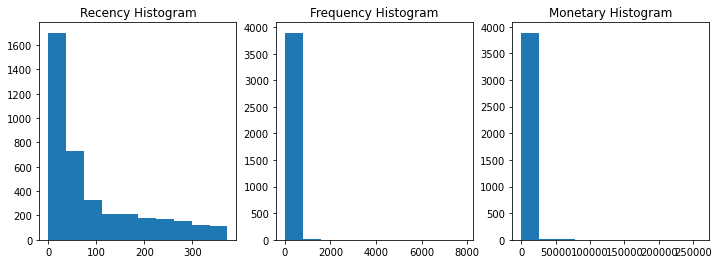

In [11]:
# matplotlib의 hist()
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(12, 4), nrows=1, ncols=3)
ax1.set_title('Recency Histogram')
ax1.hist(cust_df['Recency'])

ax2.set_title('Frequency Histogram')
ax2.hist(cust_df['Frequency'])

ax3.set_title('Monetary Histogram')
ax3.hist(cust_df['Monetary'])

Recency, Frequency, Monetary 모두 왜곡된 데이터 값 분포도를 가지고 있으며, 특히 Frequency, Monetary의 경우 특정 범위에 값이 몰려 왜곡 정도가 심하다. 각 칼럼의 데이터 값 백분위로 대략적으로 어떻게 값이 분포돼 있는지 확인.

In [12]:
cust_df[['Recency', 'Frequency', 'Monetary']].describe()

,Recency,Frequency,Monetary
count,3920.000000,3920.000000,3920.000000
mean,91.742092,90.388010,1864.385601
std,99.533485,217.808385,7482.817477
min,0.000000,1.000000,3.750000
25%,17.000000,17.000000,300.280000
50%,50.000000,41.000000,652.280000
75%,142.000000,99.250000,1576.585000
max,373.000000,7847.000000,259657.300000


* Recency
    * 평균 92.7, 50%(중위값)인 50보다 크게 높다. 그리고 max값은 373으로 75%인 142보다 훨씬 커서 왜곡 정도가 높음을 알 수 있다.
* Frequency
    * 왜곡 정도가 더 심해서 Frequency의 평균이 90.3인데, 75%인 99.25에 가깝다. 이는 max값 7847을 포함한 상위 몇 개의 큰 값으로 인한 것이다.
* Monetary
    * 평균은 1864.3으로 75%인 1578.5보다 매우 크다. 이는 max 값 259657.3을 포함한 상위 몇 개의 큰 값으로 인해 발생한 현상이다.




In [13]:
# K-평균 군집 수행
# StandardScaler로 평균과 표준편차를 재조정한 뒤 K-평균
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

X_features = cust_df[['Recency', 'Frequency', 'Monetary']].values
X_features_scaled = StandardScaler().fit_transform(X_features)

kmeans = KMeans(n_clusters=3, random_state=0)
labels = kmeans.fit_predict(X_features_scaled)
cust_df['cluster_label'] = labels

print('실루엣 스코어는 : {0:.3f}'.format(silhouette_score(X_features_scaled, labels)))

실루엣 스코어는 : 0.592


군집을 3개로 구성할 경우 전체 군집의 평균 실루엣 계수인 실루엣 스코어는 0.592로 안정적인 수치가 나왔다.

한번 군집 개수별 군집화 구성을 시각화하여 확인해본다.

In [14]:
### 여러개의 클러스터링 갯수를 List로 입력 받아 각각의 실루엣 계수를 면적으로 시각화한 함수 작성  
def visualize_silhouette(cluster_lists, X_features): 
    
    from sklearn.datasets import make_blobs
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_samples, silhouette_score

    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import math
    
    # 입력값으로 클러스터링 갯수들을 리스트로 받아서, 각 갯수별로 클러스터링을 적용하고 실루엣 개수를 구함
    n_cols = len(cluster_lists)
    
    # plt.subplots()으로 리스트에 기재된 클러스터링 만큼의 sub figures를 가지는 axs 생성 
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)
    
    # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
    for ind, n_cluster in enumerate(cluster_lists):
        
        # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산. 
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(X_features)
        
        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)
        
        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        
        # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현. 
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()
            
            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i
            
            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10
            
        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

In [15]:
### 여러개의 클러스터링 갯수를 List로 입력 받아 각각의 클러스터링 결과를 시각화 
def visualize_kmeans_plot_multi(cluster_lists, X_features):
    
    from sklearn.cluster import KMeans
    from sklearn.decomposition import PCA
    import pandas as pd
    import numpy as np
    
    # plt.subplots()으로 리스트에 기재된 클러스터링 만큼의 sub figures를 가지는 axs 생성 
    n_cols = len(cluster_lists)
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)
    
    # 입력 데이터의 FEATURE가 여러개일 경우 2차원 데이터 시각화가 어려우므로 PCA 변환하여 2차원 시각화
    pca = PCA(n_components=2)
    pca_transformed = pca.fit_transform(X_features)
    dataframe = pd.DataFrame(pca_transformed, columns=['PCA1','PCA2'])
    
     # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 KMeans 클러스터링 수행하고 시각화
    for ind, n_cluster in enumerate(cluster_lists):
        
        # KMeans 클러스터링으로 클러스터링 결과를 dataframe에 저장. 
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(pca_transformed)
        dataframe['cluster']=cluster_labels
        
        unique_labels = np.unique(clusterer.labels_)
        markers=['o', 's', '^', 'x', '*']
       
        # 클러스터링 결과값 별로 scatter plot 으로 시각화
        for label in unique_labels:
            label_df = dataframe[dataframe['cluster']==label]
            if label == -1:
                cluster_legend = 'Noise'
            else :
                cluster_legend = 'Cluster '+str(label)           
            axs[ind].scatter(x=label_df['PCA1'], y=label_df['PCA2'], s=70,\
                        edgecolor='k', marker=markers[label], label=cluster_legend)

        axs[ind].set_title('Number of Cluster : '+ str(n_cluster))    
        axs[ind].legend(loc='upper right')
    
    plt.show()

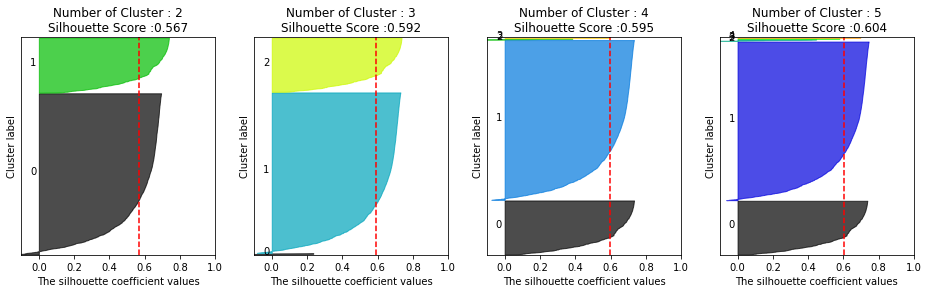

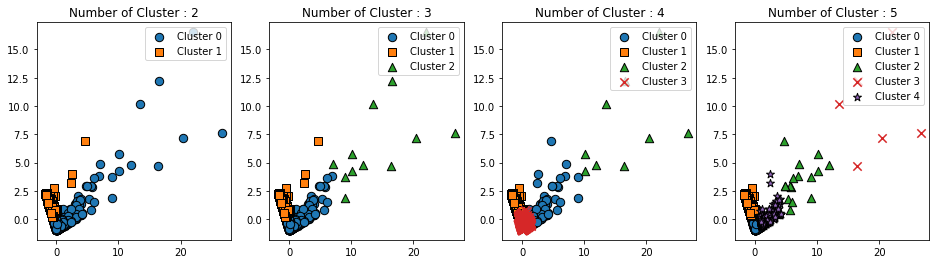

In [16]:
visualize_silhouette([2,3,4,5],X_features_scaled)
visualize_kmeans_plot_multi([2,3,4,5],X_features_scaled)

* 군집 개수 2일 경우
    * 0번 군집과 1번 군집은 너무 개괄적으로 군집화되었다.
* 군집 개수 3 이상
    * 데이터 세트의 개수가 너무 작은 군집이 만들어진다. 이 군집에 속한 데이터는 개수가 적을뿐더러 실루엣 계수 역시 상대적으로 매우 작다. 또한 군집 내부에서도 데이터가 광범위하게 퍼져있다.
    * 군집 개수 3일 경우
        * 0번 군집의 데이터 건수가 매우 작다.
    * 군집 개수 4일 경우
        * 2번, 3번 군집 데이터 건수가 매우 작다.
    * 군집 개수 5일 경우
        * 2, 3, 4번 군집에 속한 데이터 세트의 개수가 너무 적고 광범위하게 퍼져 있다.

이 소스의 데이터 세트는 왜곡된 데이터 값인 특정 소매점의 대량 주문 구매 데이터이다. 이 데이터의 경우 데이터 값이 거리 기반으로 광범위하게 퍼져 있어 군집 수를 늘려도 소용이 없다.

데이터 세트의 왜곡 정도를 낮추기 위해 가장 자주 사용되는 방법은 데이터 값에 로그(Log)를 적용. 전체 데이터를 로그 변환한 뒤에 K-평균 알고리즘을 적용하고 결과 비교.

In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

# Recency, Frequecny, Monetary 컬럼에 np.log1p() 로 Log Transformation
cust_df['Recency_log'] = np.log1p(cust_df['Recency'])
cust_df['Frequency_log'] = np.log1p(cust_df['Frequency'])
cust_df['Monetary_log'] = np.log1p(cust_df['Monetary'])

# Log Transformation 데이터에 StandardScaler 적용
X_features = cust_df[['Recency_log', 'Frequency_log', 'Monetary_log']].values
X_features_scaled = StandardScaler().fit_transform(X_features)

kmeans = KMeans(n_clusters=3, random_state=0)
labels = kmeans.fit_predict(X_features_scaled)
cust_df['cluster_label'] = labels

print('실루엣 스코어는 : {0:.3f}'.format(silhouette_score(X_features_scaled, labels)))

실루엣 스코어는 : 0.306


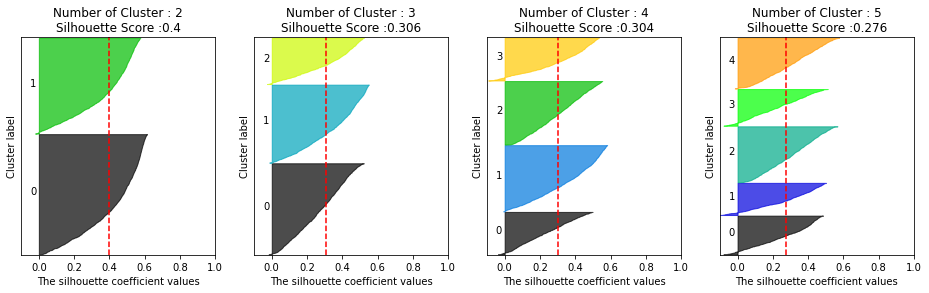

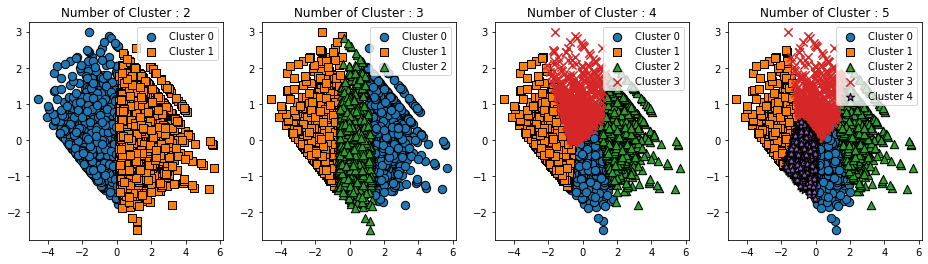

In [18]:
visualize_silhouette([2,3,4,5],X_features_scaled)
visualize_kmeans_plot_multi([2,3,4,5],X_features_scaled)

실루엣 스코어는 로그 변환하기 전보다 떨어지지만, 로그 변환 후 더 균일하게 군집화가 구성되었다. 이처럼 왜곡된 데이터 세트에 대해서는 로그 변환으로 데이터를 일차 변환한 후에 군집화를 수행하면 더 나은 결과를 도출할 수 있다.

# 결론

* K-평균 군집화 : 거리 기반으로 군집 중심점을 이동시키면서 군집화 수행
    * 매우 쉽고 직관적
    * 복잡한 구조를 가지는 데이터 세트에 적용하기에는 한계가 있으며, 군집 개수를 최적화하기 어렵다.
    * K-평균은 군집이 잘 되었는지의 평가를 위해 실루엣 계수를 이용

* 평균 이동(Mean Shift) 군집화 : 거리 중심이 아닌 데이터가 모여 있는 밀도가 가장 높은 쪽으로 군집 중심점을 이동하면서 군집화 수행.
    * 정형 데이터 세트보다 컴퓨터 비전 영역에서 이미지나 영상 데이터에서 특정 개체를 구분하거나 움직임을 추적하는 데 뛰어남.

* GMM(Gaussian Mixture Model) 군집화 : 군집화를 적용하고자 하는 데이터가 여러 개의 가우시간 분포를 모델을 섞어서 생성된 모델로 가정해 수행.
    * 전체 데이터 세트에서 서로 다른 정규 분포 형태를 추출해 이렇게 다른 정규 분포를 가진 데이터 세트를 각각 군집화.
    * K-평균보다 유연하게 다양한 데이터 세트에 잘 적용됨.
    * 수행 시간이 오래 걸림

* DBSCAN(Density Based Spatial Clustering of Application with Noise) : 밀도 기반 군집화
    * 입실론 주변 영역 내에 포함되는 최소 데이터 개수의 충족 여부에 따라 데이터 포인트를 핵심 포인트, 이웃 포인트, 경계 포인트, 잡음 포인트로 구분.
    * 특정 핵심 포인트에서 직접 접근이 가능한 다른 핵심 포인트를 서로 연결하여 군집 영역을 넓혀 군집화 구성.
    * 데이터 분포가 기하학적으로 복잡한 데이터 세트에도 효과적인 군집화가 가능.